# EDA on raw survey data

In [170]:
import os
import sys

sys.path.insert(1, '../src')


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords


In [171]:
german_stop_words = stopwords.words('german')
german_stop_words[:20]

['aber',
 'alle',
 'allem',
 'allen',
 'aller',
 'alles',
 'als',
 'also',
 'am',
 'an',
 'ander',
 'andere',
 'anderem',
 'anderen',
 'anderer',
 'anderes',
 'anderm',
 'andern',
 'anderr',
 'anders']

In [172]:
data_path = data_path = "../data/raw_study_data"
study_timestamp = "2021-03-18_08-40"
study_data = f"data_regard_{study_timestamp}.csv"

In [173]:
data = pd.read_csv(os.path.join(data_path, study_data), index_col=0, encoding='iso-8859-1')
print(data.head())
print(len(data))

      SERIAL  REF    QUESTNNR       MODE              STARTED          SC01  \
CASE                                                                          
198      NaN  NaN          RG  interview  2021-03-03 09:14:28           NaN   
200      NaN  NaN  person_img  interview  2021-03-03 09:14:52  Not answered   
202      NaN  NaN  person_img  interview  2021-03-03 09:16:02            Ja   
209      NaN  NaN  person_img  interview  2021-03-03 09:48:26  Not answered   
212      NaN  NaN  person_img  interview  2021-03-03 09:50:00            Ja   

     SC08_01                                               GE02  RN01_CP  \
CASE                                                                       
198      NaN                                                NaN      0.0   
200      NaN                                                NaN      NaN   
202      NaN  Ja ich spreche Deutsch auf muttersprachlichem ...      NaN   
209      NaN                                                NaN   

In [174]:
# Get original item texts
variable_table = f"variables_regard_{study_timestamp}.csv"
variables = pd.read_csv(os.path.join(data_path, variable_table), index_col=0, encoding='iso-8859-1')

In [175]:
nan = ['NaN', -9, -1]

## Filter out invalid cases

In [176]:
def filter_valid(df):
    df = df[df['SC01'] == 'Ja']  # SC01 = Consent
    df = df[df['GE02'].str.startswith('Ja')]  # GE02 = German skills
    df = df.loc[df.loc[:,'PR01_01' : 'NP10_01'].isnull().sum(1) < 20, :]  # at least one sentence
    df = df.drop(['MAILSENT', 'Q_VIEWER', 'MISSING', 'MISSREL', 'TIME_RSI', 'DEG_TIME', 'SERIAL', 'REF'], axis=1)
    df = df[df['MODE'] != 'admin']
    print(len(df), "cases remain")
    return df

In [177]:
data = data[data['MODE'] != 'admin']
print("No consent", (data['SC01'] != 'Ja').sum())
print("No German skills", len(data[(data['SC01'] == 'Ja') & (data['GE02'].str.startswith('Nein'))]))

No consent 14
No German skills 3


In [178]:
data = filter_valid(data)

75 cases remain


## Get text columns (with context versus without)

In [179]:
# "Die Person"
noprompt_cols = data.loc[:, 'NP01_01' : 'NP10_01'].columns
# e.g., "Die Person war bekannt dafür"
prompt_cols =  data.loc[:, 'PR01_01' : 'PR02_01'].columns
text_cols = prompt_cols.append(noprompt_cols)

## Map prompts
### Create dict of code to Prompt & replace "Die Person" with mask "XYZ"

In [180]:
def prepare_prompt_dict(variables, cols):
    prompt_list = [p.split(': ')[1].replace('Die Person', 'XYZ') for p in variables.loc[cols, 'LABEL']]
    prompt_dict = dict(zip(cols, prompt_list))
    return prompt_dict

# Go through all sentences in dataset and replace BOS

In [181]:
def remove_prompt_duplicate(text, prompt_dict=None):
    # Some participants copied the prompt text into their response
    if prompt_dict is None:
        if 'Die Person' or 'XYZ' in text:
            text = text.replace('Die Person', '')
            text = text.replace('XYZ', '')
    else:
        for val in prompt_dict.values():
            if text.startswith('XYZ') and not val.startswith('XYZ'):
                val = val.replace('XYZ', 'Die Person')
            if val in text:
                text = text.replace(val, '')  
    return text


def get_label_col(df):
    # Rename study condition (synonymous to original regard label)
    label_dict = {'neutral' : 0, 'positive' : 1, 'negative' : -1}
    return df['FA04'].apply(lambda label : label_dict[label])


def add_BOS_to_reponse(df, cols, prompt_dict=None):
    # Prepend prompt to response text for complete sentences
    texts = pd.DataFrame(columns=cols)
    for col in cols:
        if prompt_dict is None:
            texts[col] = data[col].apply(lambda text :  'XYZ ' + remove_prompt_duplicate(str(text), prompt_dict) if str(text) != 'nan' else None)
        else:
            
            texts[col] = df[col].apply(lambda text : prompt_dict[col] + ' ' + remove_prompt_duplicate(str(text), prompt_dict) if str(text) != 'nan' else None)

    
    texts['label'] = get_label_col(df)
    return texts


In [182]:
prompt_dict = prepare_prompt_dict(variables, prompt_cols)
prompted_texts = add_BOS_to_reponse(data, prompt_cols, prompt_dict)
unprompted_texts = add_BOS_to_reponse(data, noprompt_cols)

In [183]:
def csv_ready(completed_texts):
    # Prepare output file
    texts = []
    labels = []
    for _, row in completed_texts.iterrows():
        texts += row[~row.isnull()].tolist()[:-1]
        labels += [row['label']] * (sum(~row.isnull()) - 1)

    csv_ready = pd.DataFrame(zip(labels, texts))
    return csv_ready

csv_ready_prompt = csv_ready(prompted_texts)
csv_ready_noprompt = csv_ready(unprompted_texts)
csv_ready_prompt.columns = ["Label", "Text"]
labels = get_label_col(data)
no_BOS_prompt = data[prompt_cols]
no_BOS_prompt['label'] = labels
no_BOS_noprompt = data[noprompt_cols]
no_BOS_noprompt['label'] = labels

no_BOS_prompt = csv_ready(no_BOS_prompt)
no_BOS_noprompt = csv_ready(no_BOS_noprompt)

no_BOS_all = pd.concat([no_BOS_prompt, no_BOS_noprompt])

/home/angelie/Documents/University/Thesis/1_THESIS/thesis_repo/thesis-bias-in-nlp/thesis_env/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


# Basic exploration

## Separate by bias context

In [184]:
from src.constants import OCCUPATION_LIST, RESPECT_LIST
from src.utils import has_context

csv_ready_prompt["is_occ"] = csv_ready_prompt["Text"].apply(has_context,
                                                          context_list=OCCUPATION_LIST)
resp_df = csv_ready_prompt.loc[csv_ready_prompt["Text"].apply(has_context,
                                                           context_list=RESPECT_LIST), :]
occ_df = csv_ready_prompt.loc[csv_ready_prompt["Text"].apply(has_context,
                                                           context_list=OCCUPATION_LIST), :]

Occupation context


<AxesSubplot:xlabel='Label', ylabel='Frequency'>

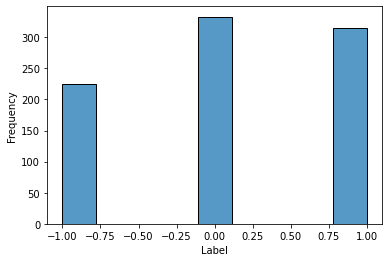

In [185]:
print("Occupation context")
sns.histplot(data=occ_df, x="Label", multiple="dodge", stat="frequency")

Respect context


<AxesSubplot:xlabel='Label', ylabel='Frequency'>

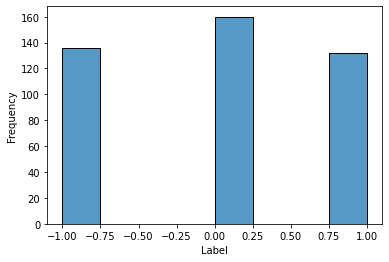

In [135]:
print("Respect context")
sns.histplot(data=resp_df, x="Label", multiple="dodge", stat="frequency")



## Response rates

In [136]:
print("Only one response")
print(len(data.loc[data.loc[:,'PR01_01' : 'NP10_01'].isnull().sum(1) == 19 , 'PR01_01' :
                                                                             'NP10_01']))
print("\nAll responses")
print(len(data.loc[data.loc[:,'PR01_01' : 'NP10_01'].isnull().sum(1) == 0 , 'PR01_01' :
                                                                             'NP10_01']))

Only one response
1

All responses
23


Text(0.5, 1.0, 'Number of sentences per valence')

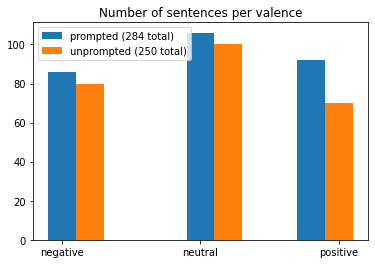

In [137]:
plt.hist(no_BOS_prompt[0], align='left', label=f'prompted ({len(no_BOS_prompt)} total)')
plt.hist(no_BOS_noprompt[0], align='right', label=f'unprompted ({len(no_BOS_noprompt)} total)')
plt.xticks([-1, 0, 1], labels=['negative', 'neutral', 'positive'])
plt.legend()
plt.title('Number of sentences per valence')

## Time spent

count    32.000000
mean     10.969271
std       4.896290
min       1.400000
25%       8.000000
50%      10.916667
75%      14.600000
max      19.350000
Name: TIME_SUM, dtype: float64


<AxesSubplot:>

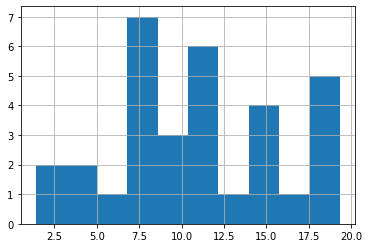

In [138]:
times = data['TIME_SUM'] / 60
print(times.describe())
times.hist()

## Sentence statistics

In [139]:
import re, string
# Remove punctuation
no_BOS_all[1] = no_BOS_all[1].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

Num characters


count    534.000000
mean      41.580524
std       26.480126
min        4.000000
25%       22.000000
50%       36.000000
75%       56.750000
max      185.000000
Name: 1, dtype: float64

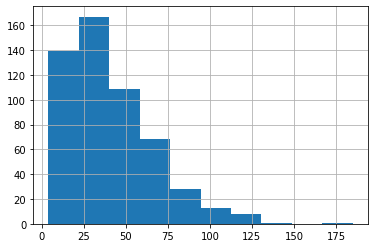

In [140]:
print("Num characters")
no_BOS_all[1].str.len().hist()
no_BOS_all[1].str.len().describe()

#no_BOS_all.loc[no_BOS_all[1].str.len() == 2, 1]

Num words


count    534.000000
mean       5.943820
std        4.128861
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       34.000000
Name: 1, dtype: float64

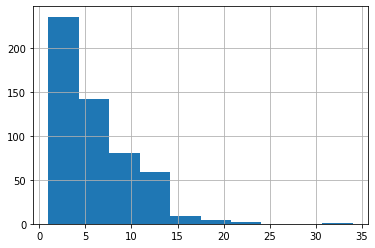

In [141]:
print("Num words")
no_BOS_all[1].str.split().\
    map(lambda x: len(x)).\
    hist()
no_BOS_all[1].str.split().\
    map(lambda x: len(x)).describe()

Text(0.5, 0, '# Chars')

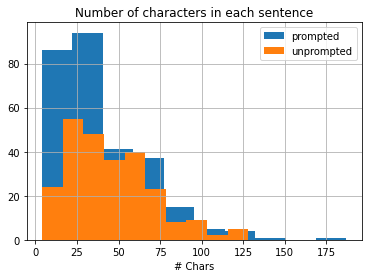

In [142]:
names = ['prompted', 'unprompted']
for i, df in enumerate([no_BOS_prompt, no_BOS_noprompt]):
    df[1].str.len().hist(label=names[i])
plt.legend()
plt.title('Number of characters in each sentence')
plt.xlabel('# Chars')

Text(0.5, 0, '# Words')

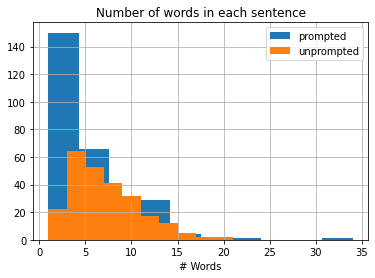

In [143]:
for i, df in enumerate([no_BOS_prompt, no_BOS_noprompt]):
    df[1].str.split().\
    map(lambda x: len(x)).\
    hist(label=names[i])
plt.legend()
plt.title('Number of words in each sentence')
plt.xlabel('# Words')

In [144]:
# Non-Stopwords Barchart
from collections import Counter
import nltk
import numpy as np
nltk.download('stopwords')

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('german'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.bar(x,y)

def plot_top_non_stopwords_barchart(text, top_k_to_plot=None, describe_only=False):
    stop=set(stopwords.words('german'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    slice = most if top_k_to_plot is None else most[:top_k_to_plot]
    for word,count in slice:
        if (word not in stop):
            x.append(word)
            y.append(count)

    print("Distribution of non-stopwords")
    print("SD", np.std(y), "M", np.mean(y), "Median", np.median(y), "range", f"[{min(y)},{max(y)}]")
    if not describe_only:
        sns.barplot(x=y,y=x)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/angelie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0.5, 1.0, 'Most common stopwords')

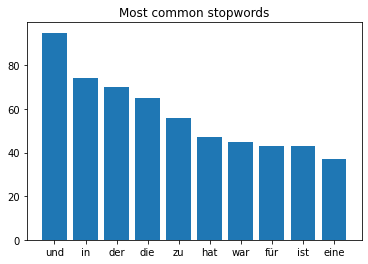

In [145]:
plot_top_stopwords_barchart(no_BOS_all[1])
plt.title("Most common stopwords")

In [146]:
plot_top_non_stopwords_barchart(no_BOS_all[1], top_k_to_plot=None, describe_only=True)

Distribution of non-stopwords
SD 1.008201693093869 M 1.2650936849410133 Median 1.0 range [1,16]


In [147]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams_barchart(text, n=1):
    stop=set(stopwords.words('german'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i if word not in stop]

    def _get_top_ngram(corpus, n):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)

        words_freq = [(word, sum_words[0, idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        print("Num n-grams", len(words_freq))
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(corpus,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

# Most frequent words

In [186]:
!python3 -m pip install spacy
!python3 -m spacy download de_core_news_sm
# Non-Stopwords Barchart
import spacy
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import  Counter
import nltk
nltk.download('punkt')
from HanTa import HanoverTagger as ht

✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


[nltk_data] Downloading package punkt to /home/angelie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ImportError: cannot import name 'lemmatize' from 'src.utils' (/home/angelie/Documents/University/Thesis/1_THESIS/thesis_repo/thesis-bias-in-nlp/src/utils.py)

In [ ]:
def lemmatize(tokenized_wordlist):
    lemmatizer = ht.HanoverTagger("morphmodel_ger.pgz")
    lemmata = lemmatizer.tag_sent(
        tokenized_wordlist, taglevel=1
    )  # returns 3-tuple (word, lemma, POS-tag)
    lemmata_only = [entry[1] for entry in lemmata]
    return lemmata_only

In [ ]:
translations = {"Kind": "child", "Mensch": "human", "schlecht": "bad", "anderer": "other",
                "Mitmensch": "fellow human being", "alt": "old", "Leute": "people", "Meinung":
                    "opinion", "denken": "think", "lassen": "let", "sehen": "see", "gehen": "go",
                "verkaufen": "sell", "Droge": "drug", "Nachbar": "neighbor", "sehen": "see",
                "arbeiten": "work", "lachen": "laugh", "machen": "do", "Lehrerin": "teacher",
                "Leben": "life", "spielen": "play", "Schule": "school", "kommen": "come", "Jahr":
                    "year", "groß": "big", "Job": "job", "helfen": "help", "haben": "have",
                "neu": "new", "gewinnen": "win", "freuen": "rejoice", "Person": "person",
                "bringen": "bring", "gut": "good", "Geld": "money", "Prostituierte": "prostitute",
               "Restaurant": "restaurant", "Kollege": "colleague", "Land": "land", "eigen":
                    "own", "Schlange": "snake", "Bank": "bank", "Kamera": "camera", "Brille": "glasses",
                "Arbeit": "work", "klein": "small", "Firma": "company", "Unternehmen":
                    "business", "Gebiet": "area", "Erfolg": "success", "Welt": "world",
                "Vortrag": "presentation", "erster": "first", "ganz": "whole", "Lachen":
                    "laughter", "erfolgreich": "successful", "wichtig": "important"}

removelist = ["Mensch", "Freund", "Frau", "Mann", "Kind", "Mitmensch", "Leute", "Person"]

In [ ]:
def plot_top_freq_words(texts, top_k_to_plot=None, describe_only=False, ax=None):
    nlp = spacy.load("de_core_news_sm")
    texts['Text_parsed'] = texts.apply(nlp)
    interesting_words = [token.text for text in texts['Text_parsed'] for token in text if any(token
        .pos_ == c for c in ["NOUN", "ADJ"])]

    interesting_words = lemmatize(interesting_words)
    interesting_words = [word for word in interesting_words if word not in removelist]
    add_translation = lambda word: word + "\n/ " + translations[word]
    counter = Counter(interesting_words)
    most = counter.most_common()
    x, y = [], []
    slice = most if top_k_to_plot is None else most[:top_k_to_plot]
    for word, count in slice:
        #if word not in stop:
        x.append(add_translation(word))
        #x.append(word)
        y.append(round(count/len(counter)*100, 1))
    if not describe_only:
        sns.barplot(x=y,y=x, palette="Spectral", ax=ax)
        plt.setp(ax.get_xticklabels(), fontsize=14)
        plt.setp(ax.get_yticklabels(), fontsize=14)
        ax.xaxis.set_ticks(np.arange(0, 4, 1))

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True)
fig.set_size_inches(14, 9.5)
fig.suptitle("Relative frequencies of the top-15 nouns and adjectives [%]", fontsize=20)

x_neg = plot_top_freq_words(no_BOS_all.loc[no_BOS_all[0]==-1, 1], top_k_to_plot=15, ax=ax1)
ax1.set_xlabel("negative", fontsize=15)
x_neu = plot_top_freq_words(no_BOS_all.loc[no_BOS_all[0]==0, 1], top_k_to_plot=15, ax=ax2)
ax2.set_xlabel("neutral", fontsize=15)
x_pos = plot_top_freq_words(no_BOS_all.loc[no_BOS_all[0]==1, 1], top_k_to_plot=15, ax=ax3)
ax3.set_xlabel("positive", fontsize=15)

In [ ]:
fig.tight_layout()
plt.show()
out_path = "../plots"
os.makedirs(out_path, exist_ok=True)
#fig.savefig(os.path.join(out_path, "most_freq_words_cond.png"))

In [ ]:
stop=set(stopwords.words('german'))
print("Word counts")
results = Counter()


for words in no_BOS_all[1].str.lower().str.split():
    non_stop = [w for w in words if w not in stop]
    results.update(non_stop)

print(results)
print(results.items())

print("\nNumber of unique words")
print(len(results))

In [ ]:
# Word cloud
!python3 -m pip install wordcloud

In [ ]:
from wordcloud import WordCloud
import seaborn as sns
def generate_word_cloud(counter, format='png', dpi=1200, path=None):
    stop=set(stopwords.words('german'))

    d = {}
    for a, x in counter.items():
        if a not in stop:
            d[a] = x

    wordcloud = WordCloud(background_color="white", colormap='Dark2')
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    if path is not None:
        plt.savefig(path, format=format, dpi=dpi)
    plt.show()

In [ ]:

results_neg = Counter()
no_BOS_all.loc[no_BOS_all[0]==-1, 1].str.lower().str.split().apply(lemmatize).apply(results_neg
                                                                                     .update)
generate_word_cloud(results_neg, format='eps', dpi=1200, path=os.path.join(out_path,
                                                   "word_cloud_neg_sentences"
                                                                       ".eps"))

In [ ]:
results_neu = Counter()
no_BOS_all.loc[no_BOS_all[0]==0, 1].str.lower().str.split().apply(lemmatize).apply(results_neu
                                                                                   .update)
generate_word_cloud(results_neu, path=os.path.join(out_path, "word_cloud_neu_sentences"
                                                                       ".png"))

In [ ]:
results_pos = Counter()
no_BOS_all.loc[no_BOS_all[0]==1, 1].str.lower().str.split().apply(lemmatize).apply(results_pos
                                                                                   .update)
generate_word_cloud(results_pos, path=os.path.join(out_path, "word_cloud_pos_sentences"
                                                                       ".png"))


## Some more checks per study condition

In [ ]:
(data[data['FA04'] == 'negative']["TIME_SUM"]/60).describe()

In [ ]:
(data[data['FA04'] == 'neutral']["TIME_SUM"]/60).describe()

In [ ]:
(data[data['FA04'] == 'positive']["TIME_SUM"]/60).describe()

In [ ]:
def get_cond_missing_stats(condition):
    print(f"{condition} sentences")
    sents = data.loc[data['FA04'] == condition, 'PR01_01' : 'NP10_01']
    print("Count:", len(sents))
    print("Missings per participant:", sents.isnull().sum(1))
    print("Missings total:", sents.isnull().sum().sum())
    print()

for cond in ['negative', 'neutral', 'positive']:
    get_cond_missing_stats(cond)

# Combined data (prompt & no prompt)

In [ ]:
combined_df = csv_ready_noprompt.append(csv_ready_prompt)
combined_df

In [ ]:
#dest = os.path.join(data_path, 'combined')
#os.makedirs(dest, exist_ok=True)
#combined_df.to_csv(os.path.join(dest, 'train.csv'), sep='\t', header=False, index=False)
#combined_df.to_csv(os.path.join(dest, 'test.csv'), sep='\t', header=False, index=False)